In [1]:
from ast import literal_eval

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from rectpack import newPacker, PackingBin
from PIL import Image
%matplotlib inline

In [3]:
def generate_plot(data, cols, size, bins=20):
    plt.figure(figsize=(size, size))
    if len(cols) == 1:
        col1 = cols[0]
        plt.hist(data[col1], bins)
        plt.xlabel(col1)
        plt.title(col1 + " Histogram")
        filename = col1 + '.png'
        plt.savefig(filename)
    else:
        col1 = cols[0]
        col2 = cols[1]
        plt.plot(data[col1], data[col2], 'o')
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.title(col1 + " impact on " + col2)
        filename = col1 + '_' + col2 + '.png'
        plt.savefig(filename)
#     plt.show()
    return filename

In [4]:
cols = [
    'Country',
    'Quality of Life Index',
    'Purchasing Power Index',
    'Safety Index',
    'Health Care Index',
    'Cost of Living Index',
    'Property Price to Income Ratio',
    'Traffic Commute Time Index',
    'Pollution Index',
    'Climate Index',
]

data = pd.read_csv('country_data.csv', '\t', header=None).set_index(0)
data.columns = cols

In [27]:
with open('importance', 'r') as f:
    importance = literal_eval(f.readlines()[0])

/home/aga/.virtualenvs/visard/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


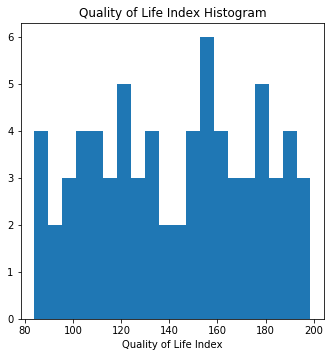

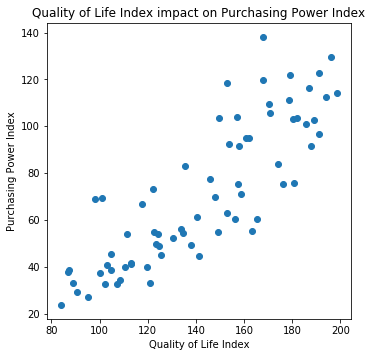

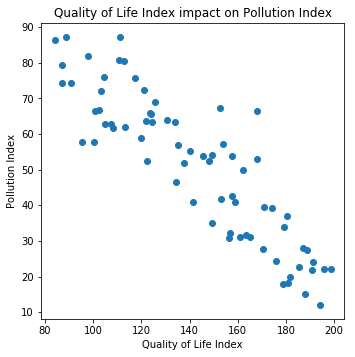

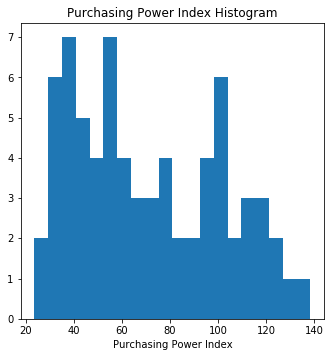

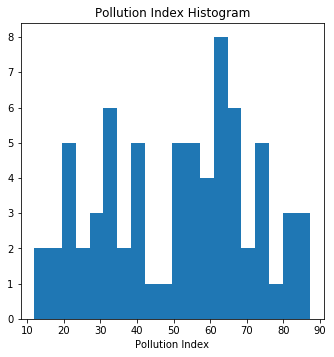

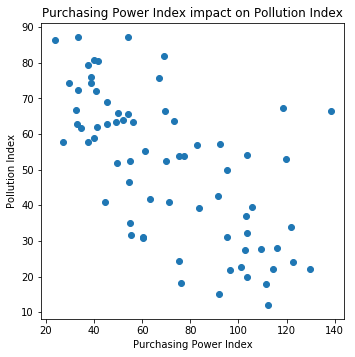

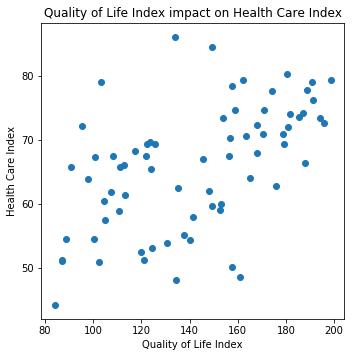

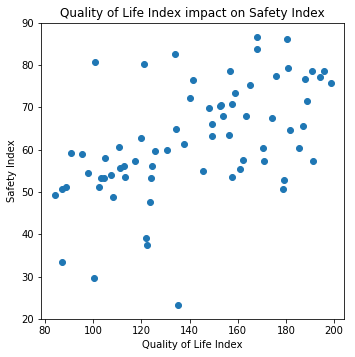

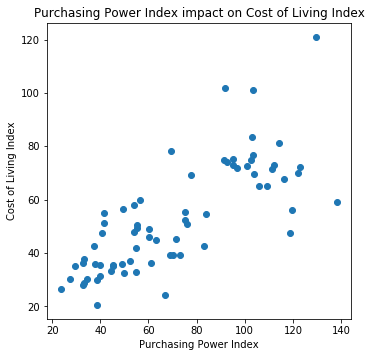

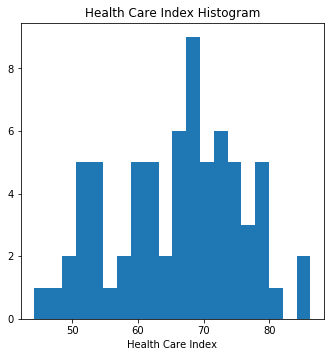

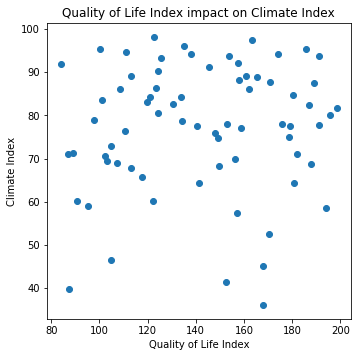

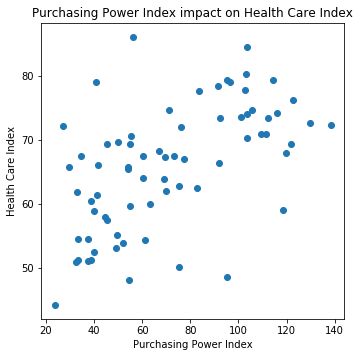

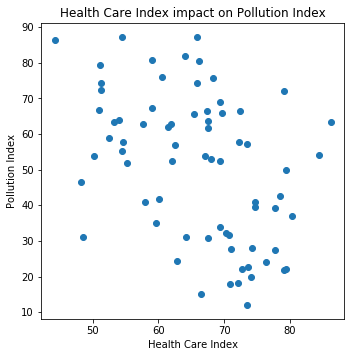

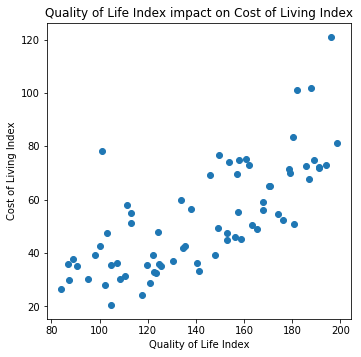

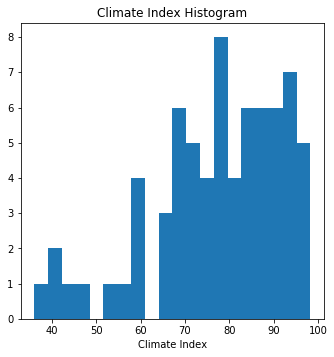

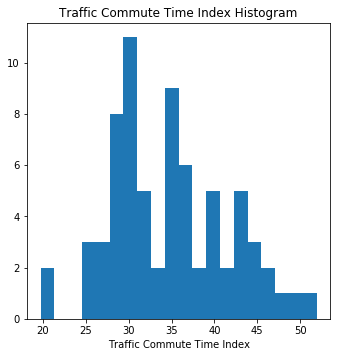

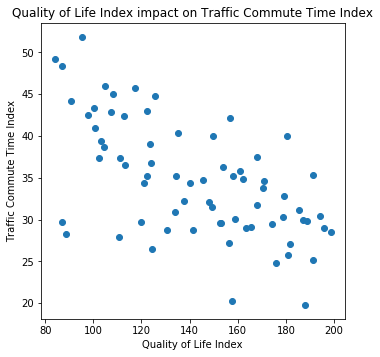

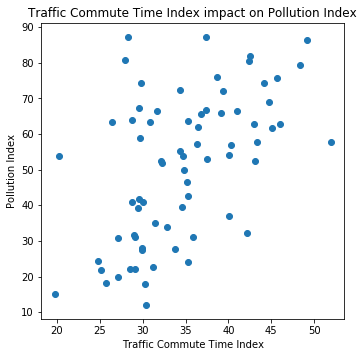

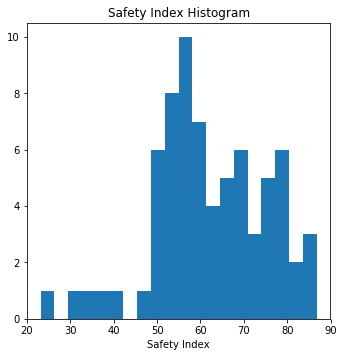

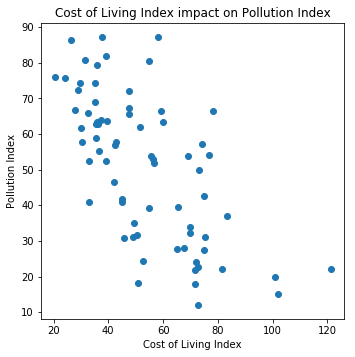

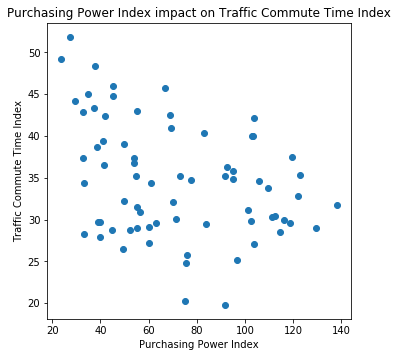

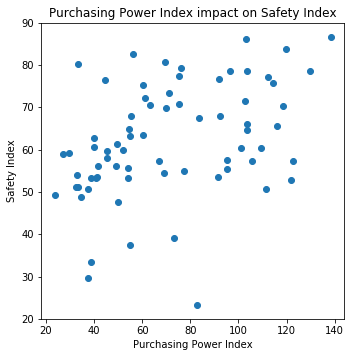

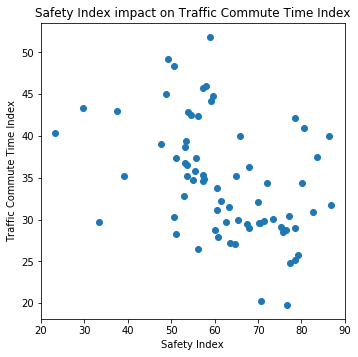

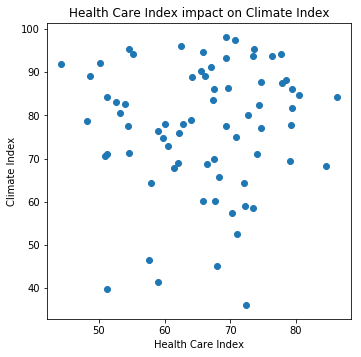

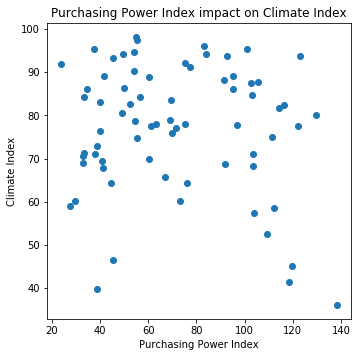

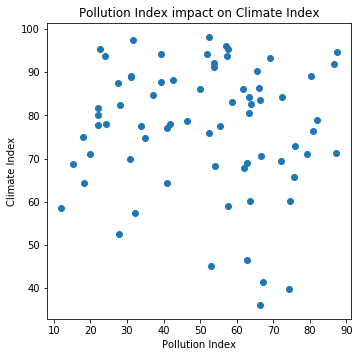

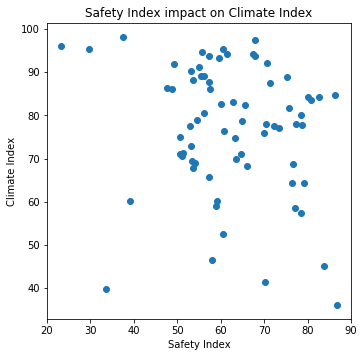

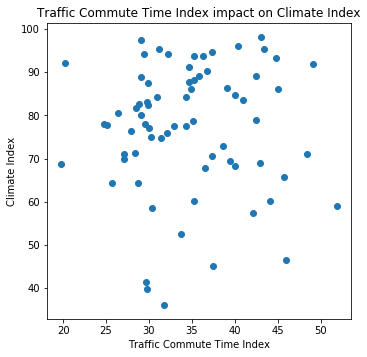

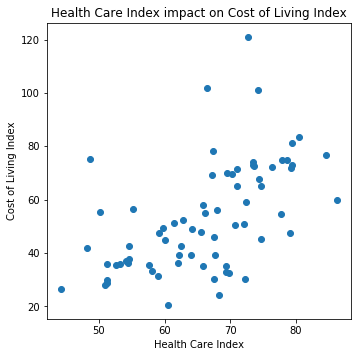

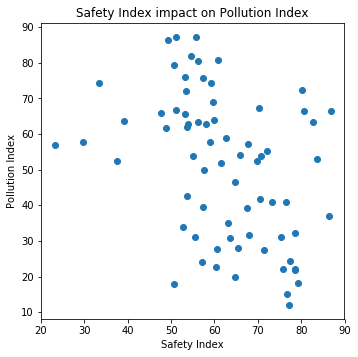

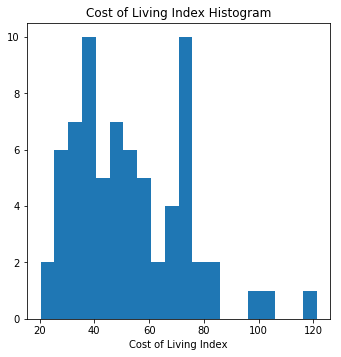

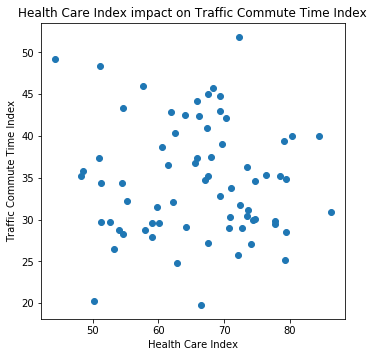

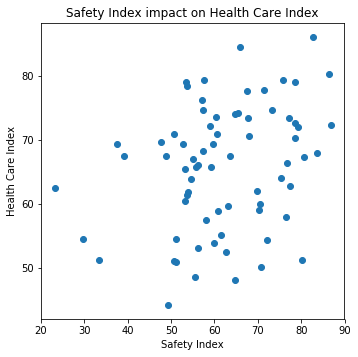

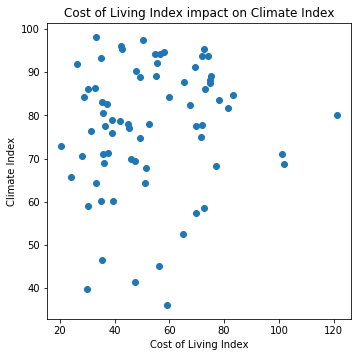

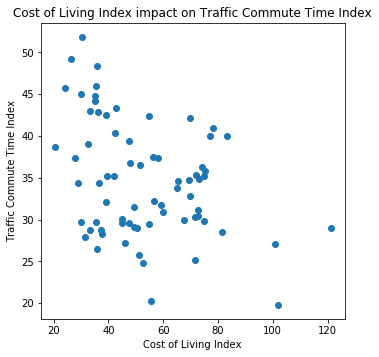

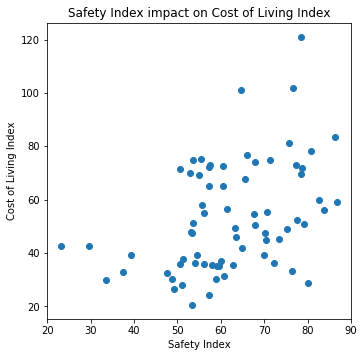

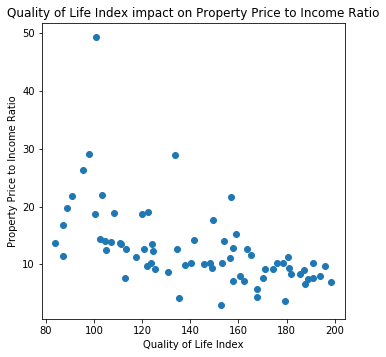

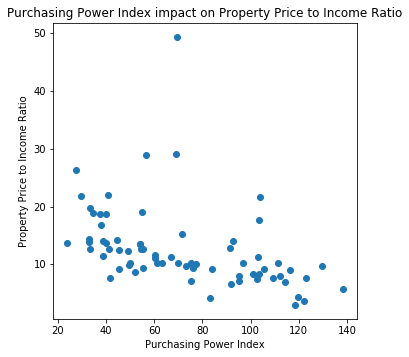

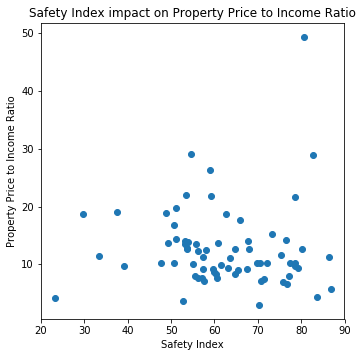

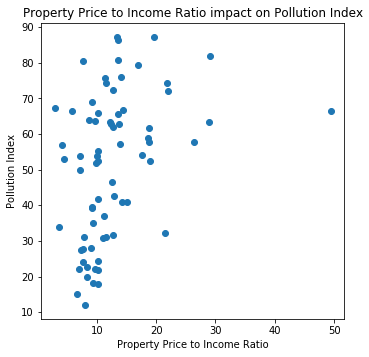

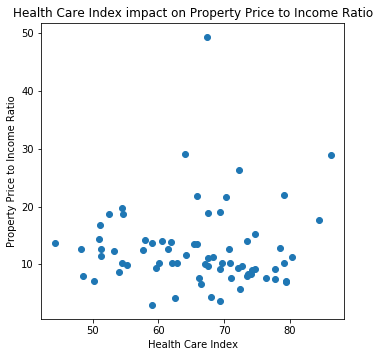

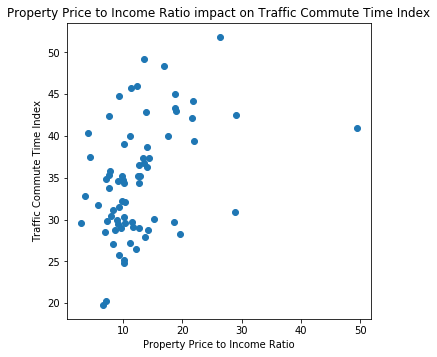

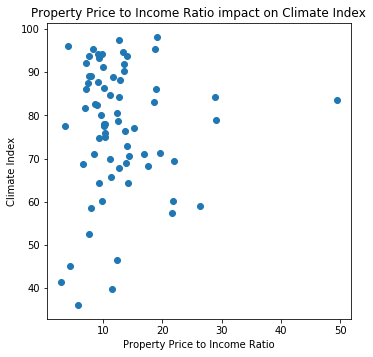

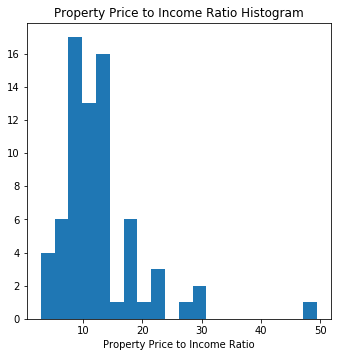

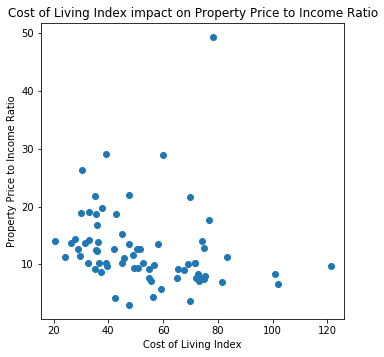

In [29]:
importance_dict = {}
for i, (cols, imp) in enumerate(importance):
    filename = generate_plot(data, cols, size)
    importance_dict[filename] = imp

In [3]:
def pack(sizes_sorted, width):
    """
    Packs squares of given sizes into box of given width (height is calculated).
    Sizes should be sorted.
    """
    rectangles = []
    area = 0
    for val in sizes_sorted:
        rectangles.append((val, val))
        area += val**2
    height = np.ceil(area/width)
    bins = [(width, height)]
    packer = newPacker(bin_algo=PackingBin.BBF)

    for r in rectangles:
        packer.add_rect(*r)
    for b in bins:
        packer.add_bin(*b)
    packer.pack()
    
    return packer, height


def get_size(imp, min_imp, width, max_rect_size):
    """Calculates size of the square on the picture"""
    return round((imp - min_imp)/(1 - min_imp) * width * max_rect_size, 2)


def gen_picture(filenames, importances, save_dir, 
                min_imp=0.7, max_rect_size=0.33, width_pixels=3000):
    """
    Generates one picture with all of the pictures given in filenames. 
    The size of the picture is calculated by `get_size` function based on 
    importance of the picture, min_imp and max_rect_size.
    :param filenames: filenames, where the pictures are stored
    :param importances: impostance of each picture from `filenames`
    :param save_dir: directory where to save the picture
    :param min_imp: minimal importance so the picture is still included
    :param max_rect_size: maximum rectangle size on the picture (between 0 and 1)
    :param width_pixels: the width of the picture in pixels
    """
    # the algorithm doesn't do well with sizes between 0 and 1, it's better to use
    # bigger numbers
    width = 100
    scale = width_pixels / width
    sizes_filenames_dict = dict()
    for i, filename in enumerate(filenames):
        imp = importances[i]
        if imp > min_imp:
            sizes_filenames_dict[filename] = get_size(imp, min_imp, width, max_rect_size)
    sizes_inv = {val: key for key, val in sizes_filenames_dict.items()}
    sizes_filenames_dict = sorted(sizes_filenames_dict.items(), key=lambda t: (t[1],t[0]))
    filenames = [x[0] for x in sizes_filenames_dict]
    sizes_sorted = [x[1] for x in sizes_filenames_dict]
    packer, height = pack(sizes_sorted, width)
    
    whole_img = np.array(Image.new('RGBA', (int(width * scale), int(height * scale))))
    for i, rect in enumerate(packer[0]):
        size = rect.width
        filename = sizes_inv[size]
        size_scaled = int(scale * size)
        img = Image.open(filename)
        img = np.array(img.resize((size_scaled, size_scaled)))
        x = int(scale * rect.x)
        y = int(scale * rect.y)
        whole_img[y:y + size_scaled, x:x + size_scaled, :] = img
    whole_img = Image.fromarray(whole_img)
    whole_img.save(save_dir)

In [4]:
gen_picture(list(importance_dict.keys()), list(importance_dict.values()), 'test.png', min_imp=0.5)

NameError: name 'importance_dict' is not defined